In [1]:
import torch
import math
import matplotlib.pyplot as plt
import sys
import os

from PIL import Image
from diffusers import FluxPipeline
from torch import Tensor
from torchvision import transforms

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

DTYPE = torch.bfloat16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pipe = FluxPipeline.from_pretrained("/root/autodl-tmp/Flux-dev", torch_dtype=DTYPE)
pipe.to(device)
print(f"Loaded pipeline to device {device}")

/root/miniconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/root/miniconda3/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loaded pipeline to device cuda


In [2]:
from models.flux_dev import FluxWrapper, encode_imgs, decode_imgs, get_time_grid, prepare_packed_latents, unpack_and_decode

height = 1024
width = 1024
height = 16 * (height // 16)
width = 16 * (width // 16)

packed_latents, latent_img_ids = prepare_packed_latents(
    batch_size=1,
	height=height,
	width=width,
    dtype=DTYPE,
    device=device,
)

img_seq_len = packed_latents.shape[1]

time_grid = get_time_grid(
    num_steps=50,
    image_seq_len=img_seq_len,
)

time_grid = [1.0 - t for t in time_grid]

flux_model = FluxWrapper(
    pipeline=pipe,
    latent_image_ids=latent_img_ids,
    dtype=DTYPE,
    device=device,
)

VAE compressed shape =  (1, 16, 128, 128)
Packed latents shape =  torch.Size([1, 4096, 64])
Latent image ids shape =  torch.Size([1, 4096, 3])


In [3]:
from rectified_flow.rectified_flow import RectifiedFlow

rf_func = RectifiedFlow(
    data_shape=packed_latents.shape,
    model=flux_model,
    interp="straight",
    device=device,
	dtype=DTYPE,
)

In [4]:
from rectified_flow.samplers import EulerSampler

def print_time_callback(sampler):
    """A callback function to print the current time t."""
    print(f"Current time: {sampler.t:.4f}")
    
my_callback = [print_time_callback]

euler_sampler = EulerSampler(
    rectified_flow=rf_func,
    callbacks=my_callback,
)

euler_sampler.sample_loop(
    X_0=packed_latents,
    time_grid=time_grid,
    prompt="A photo of a cat holding a camera",
    guidance_scale=3.5,
)

/root/rectified-flow/models/flux_dev.py:63: UserWarning: X_t was moved to the device cuda of the FluxWrapper.
  warnings.warn(f"X_t was moved to the device {self.device} of the FluxWrapper.")


Prompt A photo of a cat holding a camera encoded.
Current time: 0.0000
Current time: 0.0064
Current time: 0.0130
Current time: 0.0198
Current time: 0.0268
Current time: 0.0340
Current time: 0.0414
Current time: 0.0490
Current time: 0.0569
Current time: 0.0650
Current time: 0.0734
Current time: 0.0820
Current time: 0.0909
Current time: 0.1001
Current time: 0.1096
Current time: 0.1195
Current time: 0.1297
Current time: 0.1402
Current time: 0.1512
Current time: 0.1625
Current time: 0.1743
Current time: 0.1865
Current time: 0.1992
Current time: 0.2124
Current time: 0.2262
Current time: 0.2405
Current time: 0.2554
Current time: 0.2710
Current time: 0.2872
Current time: 0.3042
Current time: 0.3220
Current time: 0.3406
Current time: 0.3602
Current time: 0.3807
Current time: 0.4022
Current time: 0.4249
Current time: 0.4488
Current time: 0.4740
Current time: 0.5007
Current time: 0.5289
Current time: 0.5588
Current time: 0.5906
Current time: 0.6244
Current time: 0.6604
Current time: 0.6990
Curre

In [8]:
X_1_packed_latent = euler_sampler.trajectories[-1]
X_1_packed_latent = X_1_packed_latent.clone().to(device=device, dtype=DTYPE)
print(X_1_packed_latent.shape)

torch.Size([1, 4096, 64])


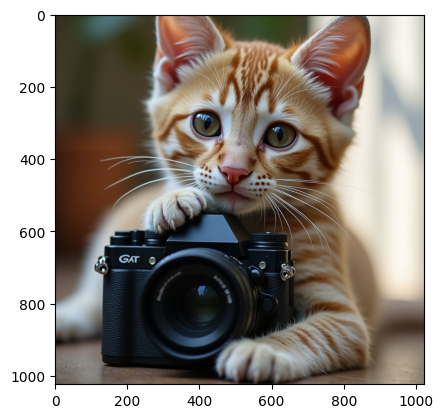

In [11]:
img = unpack_and_decode(pipe, X_1_packed_latent, height, width)

plt.imshow(img)